# Dependencies

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits import mplot3d
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Datasets

In [105]:
# def get_spiral_data(n=5000, plot=False):
#     """Get spiral dataset of x=(n,1), y=(n,2)."""
    
#     z_data = np.float32(np.random.uniform(-10.5, 10.5, n))
#     r_data = np.random.normal(size=n)
#     s_data = np.random.normal(size=n)
#     x_data = np.sin(0.75 * z_data) * 7.0 + z_data * 0.5 + r_data * 1.0
#     y_data = np.cos(0.80 * z_data) * 6.5 + z_data * 0.5 + s_data * 1.0
    
#     x_input = z_data.reshape((n, 1)).astype(np.float32)
#     y_input = np.array([x_data,y_data]).T.astype(np.float32)
    
#     if plot:
#         ax = plt.axes(projection='3d')
#         ax.scatter(x_data, y_data, z_data, alpha=0.3, c='r')
#         plt.show()
    
#     return x_input, y_input

In [106]:
# def get_normal_data(n=1000, plot=False, xy_features=(2,1)):
#     """Get normal dataset of x=(n*4,2), y=(n*4,1)."""
#     x0 = np.concatenate([
#         np.random.normal(10, 2, size=n),
#         np.random.normal(10, 2, size=n),
# #         np.random.normal(20, 2, size=n),
# #         np.random.normal(20, 2, size=n),
#     ])
#     x1 = np.concatenate([
#         np.random.normal(30, 2, size=n),
#         np.random.normal(40, 2, size=n),
# #         np.random.normal(30, 2, size=n),
# #         np.random.normal(40, 2, size=n),
#     ])
#     y = np.concatenate([
#         np.random.normal(50, 2, size=n),
#         np.random.normal(60, 2, size=n),
# #         np.random.normal(70, 2, size=n),
# #         np.random.normal(80, 2, size=n),
#     ])
#     data = np.stack((x0, x1, y), axis=1).astype(np.float32)
#     np.random.shuffle(data)
    
#     if plot:
#         ax = plt.axes(projection='3d')
#         ax.scatter(data[:,0], data[:,1], data[:,2], alpha=0.3, c='r')
#         plt.show()
    
#     return (data[:,:2], np.expand_dims(data[:,2], axis=1)) \
#             if xy_features == (2,1) else \
#             (np.expand_dims(data[:,0], axis=1), data[:,1:])

In [107]:
# n = 1000

# # Use spiral dataset
# X, y = get_spiral_data(n)
# print(X.shape, y.shape)

# # Use wholesale dataset
# df = pd.read_csv("data/wholesale.csv")
# X = df[['Channel', 'Region']].values.astype(np.float32)
# y = df[['Fresh', 'Milk']].values.astype(np.float32)

# # Use normal dataset
# X, y = get_normal_data(n, xy_features=(2,1))
# print("X, y shapes:", X.shape, y.shape)

# # Plot 2D or 3D graph according to X dimension
# plot_data(X, y)

# # Convert to TF dataset
# n = len(X)
# dataset = tf.data.Dataset \
#     .from_tensor_slices((X,y)) \
#     .shuffle(n).batch(n)

In [108]:
def plot_data(X, y):
    """Plot 2D or 3D according to X dimension."""
    if X.shape[1] == 1:
        for i in range(y.shape[1]):
            plt.plot(X, y[:,i], '.')
            plt.show()
    if X.shape[1] == 2:
        for i in range(y.shape[1]):
            ax = plt.axes(projection='3d')
            ax.scatter(X[:,0], X[:,1], y[:,i], c=y[:,i], cmap='viridis')
            plt.show()

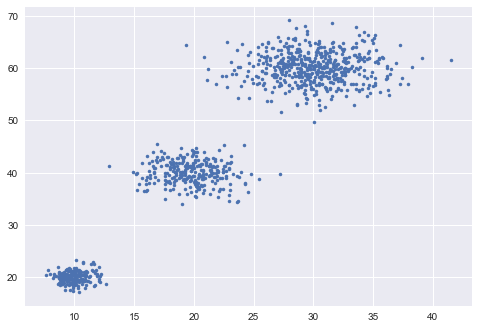

In [109]:
# Generate known parameters of a multivariate mixture of Gaussians
pi = np.array([0.2, 0.3, 0.5], dtype=np.float32)
mu = np.array([[10, 20],
               [20, 40],
               [30, 60]], dtype=np.float32)
sigma = np.array([[1, 1],
                  [2, 2],
                  [3, 3]], dtype=np.float32)

mvgmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=pi),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=mu,
        scale_diag=sigma)
)

X = mvgmm.sample(1000).numpy()
X, y = X[:,0][:,np.newaxis], X[:,1][:,np.newaxis]
plot_data(X, y)

n = len(X)
dataset = tf.data.Dataset \
    .from_tensor_slices((X,y)) \
    .shuffle(n).batch(32)

# Gaussian Mixture Density Network

* Mixing coefficients represented as softmax outputs
* Variances represented as exponentials
* Means represented directly

https://cedar.buffalo.edu/~srihari/CSE574/Chap5/Chap5.6-MixDensityNetworks.pdf

In [110]:
# 1 GMM PER SAMPLE
class GMM:
    """Gaussian Mixture Density Network."""
    def __init__(self, x_features=2, y_features=1, n_components=4, n_hidden=50, verbose=False):
        self.x_features = x_features  # no. of input features
        self.y_features = y_features  # no. of output features
        self.n_components = n_components  # no. of components
        self.n_hidden = n_hidden  # no. of hidden units 
        self.verbose = verbose
        self.build()
    
    def build(self):
        """Compile TF model."""
        input = tf.keras.Input(shape=(self.x_features,))  # (None,2)
        layer = tf.keras.layers.Dense(self.n_hidden, activation='tanh')(input)  # (None,50)

        mu = tf.keras.layers.Dense(self.n_components * self.y_features)(layer) # (None,6)
        sigma = tf.keras.layers.Dense(self.n_components * self.y_features, activation='exponential')(layer) # (None,6)
        pi = tf.keras.layers.Dense(self.n_components, activation='softmax')(layer)  # (None,3)

        self.model = tf.keras.models.Model(input, [pi, mu, sigma])
        self.optimizer = tf.keras.optimizers.Adam()
        
        if self.verbose:
            print(self.model.summary())
        
    def tfdGMM(self, pi, mu, sigma):
        """Tensorflow Probability Distributions GMM."""
        mu = tf.reshape(mu, (self.n_components, self.y_features))
        sigma = tf.reshape(sigma, (self.n_components, self.y_features))
        return tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(logits=pi),
            components_distribution=tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma))

    def loss(self, y, pi, mu, sigma):
        samples = pi.shape[0]
        losses = 0
        for i in range(samples):
            gmm = self.tfdGMM(pi[i], mu[i][:,tf.newaxis], sigma[i][:,tf.newaxis])
            loss = tf.reduce_sum(tf.negative(gmm.log_prob(y)))
            losses += loss
        return losses / samples
    
    @tf.function
    def train_step(self, X, y):
        """TF train function."""
        with tf.GradientTape() as t:
            pi, mu, sigma = self.model(X, training=True)
            loss = self.loss(y, pi, mu, sigma)
        gradients = t.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss
    
    def fit(self, dataset, epochs=1000, plot=False):
        """Fit with TF dataset."""
        losses = []
        print_every = int(0.1 * epochs)
        
        for i in range(epochs):
            for train_x, train_y in dataset:
                loss = self.train_step(train_x, train_y)
            losses.append(loss)
            if self.verbose and i % print_every == 0:
                print('Epoch {}/{}: Loss(NLL) {}'.format(i, epochs, losses[-1]))
        
        if plot:
            plt.plot(range(len(losses)), losses)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training loss (NLL)')
            plt.show()
        
    def predict(self, X):
        pi, mu, sigma = self.model(X)
        samples = pi.shape[0]
        y_pred = []
        for i in range(samples):
            y_pred.append(self.tfdGMM(pi[i], mu[i][:,tf.newaxis], sigma[i][:,tf.newaxis]).sample().numpy())
        return np.array(y_pred)

In [112]:
# AVERAGING PARAMETERS
class GMM:
    """Gaussian Mixture Density Network."""
    def __init__(self, x_features=2, y_features=1, n_components=4, n_hidden=50, verbose=False):
        self.x_features = x_features  # no. of input features
        self.y_features = y_features  # no. of output features
        self.n_components = n_components  # no. of components
        self.n_hidden = n_hidden  # no. of hidden units 
        self.verbose = verbose
        self.build()
    
    def build(self):
        """Compile TF model."""
        input = tf.keras.Input(shape=(self.x_features,))  # (None,2)
        layer = tf.keras.layers.Dense(self.n_hidden, activation='tanh')(input)  # (None,50)

        mu = tf.keras.layers.Dense(self.n_components * self.y_features)(layer) # (None,6)
        sigma = tf.keras.layers.Dense(self.n_components * self.y_features, activation='exponential')(layer) # (None,6)
        pi = tf.keras.layers.Dense(self.n_components, activation='softmax')(layer)  # (None,3)

        self.model = tf.keras.models.Model(input, [pi, mu, sigma])
        self.optimizer = tf.keras.optimizers.Adam()
        
        if self.verbose:
            print(self.model.summary())
        
    def tfdGMM(self, pi, mu, sigma):
        """Tensorflow Probability Distributions GMM."""
        mu = tf.reshape(mu, (self.n_components, self.y_features))
        sigma = tf.reshape(sigma, (self.n_components, self.y_features))
        return tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(logits=pi),
            components_distribution=tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma))

    def loss(self, y, pi, mu, sigma):
        pi = tf.math.reduce_mean(pi, axis=0)
        mu = tf.math.reduce_mean(mu, axis=0)
        sigma = tf.math.reduce_mean(sigma, axis=0)
        gmm = self.tfdGMM(pi, mu, sigma)
        loss = tf.reduce_sum(tf.negative(gmm.log_prob(y)))
        return loss
    
    @tf.function
    def train_step(self, X, y):
        """TF train function."""
        with tf.GradientTape() as t:
            pi, mu, sigma = self.model(X, training=True)
            loss = self.loss(y, pi, mu, sigma)
        gradients = t.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss
    
    def fit(self, dataset, epochs=1000, plot=False):
        """Fit with TF dataset."""
        losses = []
        print_every = int(0.1 * epochs)
        
        for i in range(epochs):
            for train_x, train_y in dataset:
                loss = self.train_step(train_x, train_y)
            losses.append(loss)
            if self.verbose and i % print_every == 0:
                print('Epoch {}/{}: Loss(NLL) {}'.format(i, epochs, losses[-1]))
        
        if plot:
            plt.plot(range(len(losses)), losses)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training loss (NLL)')
            plt.show()
        
    def predict(self, X):
        pi, mu, sigma = self.model(X)
        samples = pi.shape[0]
        y_pred = []
        for i in range(samples):
            y_pred.append(self.tfdGMM(pi[i], mu[i][:,tf.newaxis], sigma[i][:,tf.newaxis]).sample().numpy())
        return np.array(y_pred)

# Model Training

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_99 (Dense)                (None, 10)           20          input_26[0][0]                   
__________________________________________________________________________________________________
dense_102 (Dense)               (None, 3)            33          dense_99[0][0]                   
__________________________________________________________________________________________________
dense_100 (Dense)               (None, 3)            33          dense_99[0][0]                   
___________________________________________________________________________________________

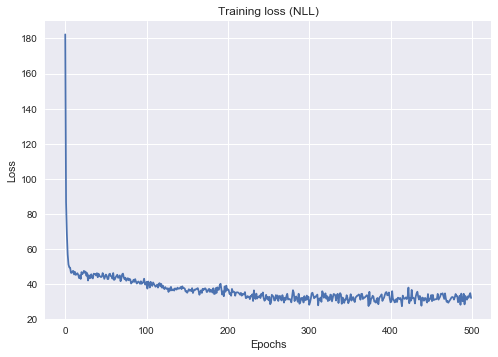

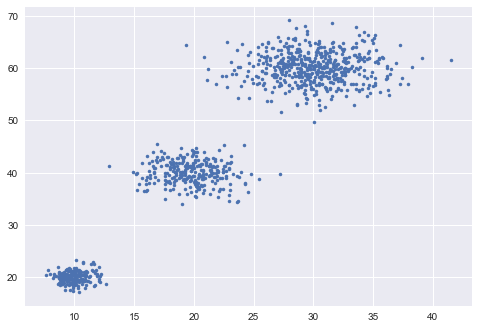

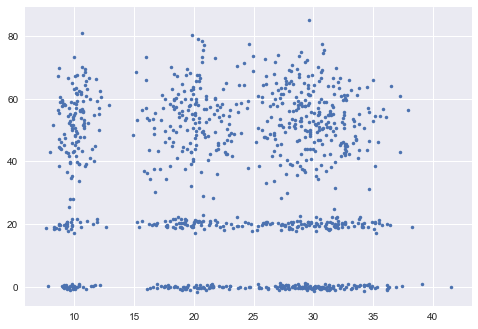

In [113]:
# Build GMM
gmm = GMM(x_features=1,
          y_features=1,
          n_components=3,
          n_hidden=10, verbose=True)
gmm.fit(dataset, epochs=500, plot=True)
y_hat = gmm.predict(X)
plot_data(X, y)
plot_data(X, y_hat)

# Probability Density Visualisation

In [ ]:
def prob_plot(self, X_r, y_r, n_tiles=20, wrt_y=True, wrt_x=False):
    """Given a GMM and range of X and y, plot a surface plot."""

    # No. of features
    X_n, y_n = len(X_r), len(y_r)

    # Only handles up to 2D values
    if X_n > 2 or y_n > 2:
        return

    # Plot with respect to y
    if wrt_y:
        # 2D plot for y-axis
        if y_n == 2:
            X = np.linspace(X_r[0][0], X_r[0][1], n_tiles**2)  # TODO: Should fix an x particular value
            y_0 = np.linspace(y_r[0][0], y_r[0][1], n_tiles)
            y_1 = np.linspace(y_r[1][0], y_r[1][1], n_tiles)

            y0, y1 = np.meshgrid(y_0, y_1)
            y = np.stack((y0.flatten(), y1.flatten()), axis=1)
            y = np.squeeze(y)

            mix = self.tfdGMM(*self.model.predict(X))
            prob = mix.prob(y).numpy().reshape((n_tiles, n_tiles))

            ax = plt.axes(projection='3d')
            plt.title("Probability with respect to y")
            ax.plot_surface(y0, y1, prob, cmap='viridis')
            plt.show()

        # 1D plot for y-axis
        elif y_n == 1:
            X_0 = np.linspace(X_r[0][0], X_r[0][1], n_tiles)
            X_1 = np.linspace(X_r[1][0], X_r[1][1], n_tiles)
            y = np.linspace(y_r[0][0], y_r[0][1], n_tiles)

            X = np.stack((X_0, X_1), axis=1)
            y = np.expand_dims(y, axis=1)

            mix = self.tfdGMM(*self.model.predict(X))
            prob = mix.prob(y).numpy()

            plt.title("Probability with respect to y")
            plt.plot(y, prob)
            plt.show()

    # Plot with respect to X
    if wrt_x:
        # 2D plot for X-axis
        if X_n == 2:
            X_0 = np.linspace(X_r[0][0], X_r[0][1], n_tiles)  # TODO: Only X
            X_1 = np.linspace(X_r[1][0], X_r[1][1], n_tiles)
            y = np.linspace(y_r[0][0], y_r[0][1], n_tiles**2)
            y = np.expand_dims(y, axis=1)

            X0, X1 = np.meshgrid(X_0, X_1)
            X = np.stack((X0.flatten(), X1.flatten()), axis=1)
            X = np.squeeze(X)

            mix = self.tfdGMM(*self.model.predict(X))
            prob = mix.prob(y).numpy().reshape((n_tiles, n_tiles))

            ax = plt.axes(projection='3d')
            plt.title("Probability with respect to X")
            ax.plot_surface(X0, X1, prob, cmap='viridis')
            plt.show()

        # 1D plot for X-axis
        if X_n == 1:
            X = np.linspace(X_r[0][0], X_r[0][1], n_tiles)
            y_0 = np.linspace(y_r[0][0], y_r[0][1], n_tiles)
            y_1 = np.linspace(y_r[1][0], y_r[1][1], n_tiles)

            X = np.expand_dims(X, axis=1)
            y = np.stack((y_0, y_1), axis=1)

            mix = self.tfdGMM(*self.model.predict(X))
            prob = mix.prob(y).numpy()

            plt.title("Probability with respect to X")
            plt.plot(X, prob)
            plt.show()

In [94]:
def get_min_max(X, adjust_min=0, adjust_max=0):
    """Get the min and max of X in [[min, max]] format."""
    Xrange = []
    for i in range(X.shape[1]):
        Xrange.append([min(X[:,i]) + adjust_min,
                       max(X[:,i]) + adjust_max])
    return Xrange

Xrange = get_min_max(X)
# yrange = get_min_max(y)
# Xrange = [[9.999,10]]
yrange = [[50,50], [70,70]]

gmm.prob_plot(Xrange, yrange, n_tiles=40, wrt_y=True, wrt_x=True)

ValueError: in user code:

    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\keras\engine\training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\keras\engine\training.py:1122 predict_step  **
        return self(x, training=False)
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\keras\engine\network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\keras\engine\network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:886 __call__
        self.name)
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer base_layer is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape [32, 1]


# Distance Metrics

In [615]:
np.mean(gmm.get_gmm(X).log_prob(y).numpy())

-8.8625765

In [607]:
Xrange = get_min_max(X)
yrange = get_min_max(y)

In [608]:
x_test = np.linspace(Xrange[0][0], Xrange[0][1], 40)
y0 = np.linspace(yrange[0][0], yrange[0][1], 40)
y1 = np.linspace(yrange[1][0], yrange[1][1], 40)
y_test = np.stack((y0, y1), axis=1)

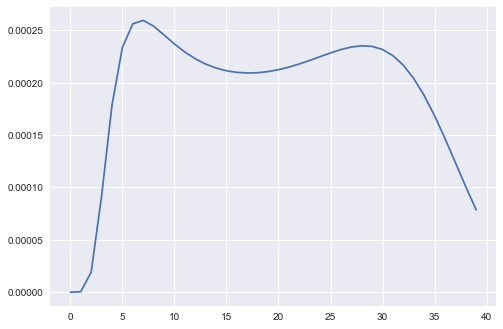

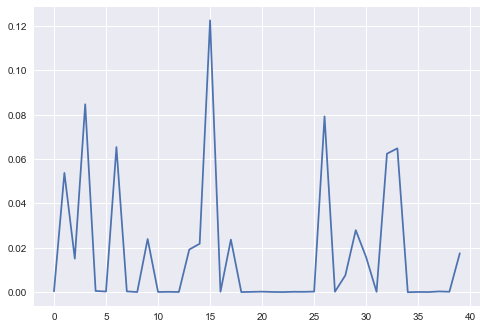

In [609]:
y_prob = gmm.get_gmm(x_test).prob(y_test).numpy()
plt.plot(y_prob)
plt.show()

y_pred = gmm.predict(x_test)
y_hat_prob = gmm.get_gmm(x_test).prob(y_pred).numpy()
plt.plot(y_hat_prob)
plt.show()

In [610]:
entropy(y_prob, y_hat_prob)

2.6924958